In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision.models import alexnet
import torchvision.transforms as transforms

import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
# --- Core Computational Utilities ---

def compute_spectral_norm(matrix):
    """
    Computes the spectral norm of a matrix.
    """
    
    return torch.linalg.matrix_norm(matrix, ord=2)

In [3]:
def compute_l21_norm(matrix):
    """
    Computes the L(2,1) norm of a matrix: L2 norm of columns, then L1 of the result.
    """
    return torch.sum(torch.linalg.norm(matrix, ord=2, dim=0))

In [4]:
# --- Main Calculation Engine ---

def compute_spectral_complexity(model: nn.Module):
    """
    Computes the spectral complexity R_A for a given PyTorch model.
    """
    product_terms = list()
    summation_terms = list()
    
    device = next(model.parameters()).device

    max_layer_time = 0
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            print(f"Processing layer: {name} of type {type(module).__name__}")

            A_i = module.weight.data
            rho_i = 1.0  # Lipschitz constant for ReLU is 1
            
            start_time = time.perf_counter()

            if A_i.dim() == 4:
                A_i = A_i.view(A_i.size(0), -1)
            
            # 1. Compute spectral norm and product term
            s_i = compute_spectral_norm(A_i)
            
            
            
            # 2. Construct the reference matrix M_i
            M_i = torch.zeros_like(A_i)
            
            # 3. Compute the deviation term for the summation
            # Formula requires ||A_i^T - M_i^T||_{2,1}
            deviation_matrix_T = A_i.T - M_i.T
            deviation_norm = compute_l21_norm(deviation_matrix_T)
            

            # Add a small epsilon to avoid division by zero if spectral norm is 0
            # sum_term = (deviation_norm**(2/3)) / ((s_i + 1e-12)**(2/3))
            sum_term = (deviation_norm / s_i)**(2/3)
            end_time = time.perf_counter()

            max_layer_time = max(max_layer_time, end_time - start_time)
            # sum_term = (deviation_norm / s_i)**(2/3)
            summation_terms.append(sum_term)
            product_terms.append(rho_i * s_i)

    # Calculate the final components
    # Product term: prod(rho_i * ||A_i||_sigma)
    total_product = torch.prod(torch.stack(product_terms))
    
    # Summation term: (sum(...))^(3/2)
    total_sum = torch.sum(torch.stack(summation_terms))
    final_sum_term = total_sum**(3/2)
    
    # Final Spectral Complexity R_A
    R_A = total_product * final_sum_term

    print(f"Maximum Computation Time for Layer: {max_layer_time:.4f}s")
    
    return R_A, total_product, final_sum_term

In [12]:
def compute_gamma_distribution(model_path):
    print("Loading pretrained AlexNet model...")
    # Load pre-trained AlexNet
    model = alexnet(pretrained=True)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 10)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        
    # Set the model to evaluation mode
    model.eval()
        
    # Compute the spectral complexity
    print("\nComputing spectral complexity...")
    start_time = time.perf_counter()
    spectral_complexity, product_component, sum_component = compute_spectral_complexity(model)
    end_time = time.perf_counter()
    print(f"Total Computation Time: {end_time - start_time:.4f}s")
        
    print("\n--- Results ---")
    print(f"Product Component (Lipschitz-like term): {product_component.item():.4e}")
    print(f"Summation Component (Structural Deviation term): {sum_component.item():.4e}")
    print(f"Total Spectral Complexity (R_A): {spectral_complexity.item():.4e}")

    transform = transforms.Compose([
        transforms.Resize(224),  # Resize for AlexNet
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # CIFAR-10 mean/std
    ])
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    num_samples = len(testset)
    data_l2_norm = 0
    
    diffs = []
    
    with torch.no_grad():
        pbar = tqdm(testloader, desc=f"Eval: ")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            top2 = torch.topk(outputs, k=2, dim=1).values
            diffs.extend((top2[:, 0] - top2[:, 1]).cpu().numpy())
            data_l2_norm += torch.sum(inputs**2)

    normal_diffs = np.array(diffs)/(spectral_complexity.item() * (torch.sqrt(data_l2_norm) / num_samples))

    return normal_diffs

    # return np.array(diffs)

In [13]:
underfit = compute_gamma_distribution("ckpt_alexnet_cifar10/epoch_1.pth")
correct = compute_gamma_distribution("ckpt_alexnet_cifar10/epoch_16.pth")
overfit = compute_gamma_distribution("ckpt_alexnet_cifar10/epoch_100.pth")

Loading pretrained AlexNet model...

Computing spectral complexity...
Processing layer: features.0 of type Conv2d
Processing layer: features.3 of type Conv2d
Processing layer: features.6 of type Conv2d
Processing layer: features.8 of type Conv2d
Processing layer: features.10 of type Conv2d
Processing layer: classifier.1 of type Linear
Processing layer: classifier.4 of type Linear
Processing layer: classifier.6 of type Linear
Maximum Computation Time for Layer: 2.1164s
Total Computation Time: 3.5903s

--- Results ---
Product Component (Lipschitz-like term): 2.4727e+05
Summation Component (Structural Deviation term): 2.8127e+03
Total Spectral Complexity (R_A): 6.9549e+08


Eval: 100%|██████████| 79/79 [00:17<00:00,  4.47it/s]


Data L2 Norm: 4.731178283691406
Loading pretrained AlexNet model...

Computing spectral complexity...
Processing layer: features.0 of type Conv2d
Processing layer: features.3 of type Conv2d
Processing layer: features.6 of type Conv2d
Processing layer: features.8 of type Conv2d
Processing layer: features.10 of type Conv2d
Processing layer: classifier.1 of type Linear
Processing layer: classifier.4 of type Linear
Processing layer: classifier.6 of type Linear
Maximum Computation Time for Layer: 5.1732s
Total Computation Time: 9.1511s

--- Results ---
Product Component (Lipschitz-like term): 2.9241e+05
Summation Component (Structural Deviation term): 2.8165e+03
Total Spectral Complexity (R_A): 8.2359e+08


Eval: 100%|██████████| 79/79 [00:18<00:00,  4.18it/s]


Data L2 Norm: 4.731178283691406
Loading pretrained AlexNet model...

Computing spectral complexity...
Processing layer: features.0 of type Conv2d
Processing layer: features.3 of type Conv2d
Processing layer: features.6 of type Conv2d
Processing layer: features.8 of type Conv2d
Processing layer: features.10 of type Conv2d
Processing layer: classifier.1 of type Linear
Processing layer: classifier.4 of type Linear
Processing layer: classifier.6 of type Linear
Maximum Computation Time for Layer: 2.1378s
Total Computation Time: 3.6250s

--- Results ---
Product Component (Lipschitz-like term): 4.0258e+05
Summation Component (Structural Deviation term): 2.8268e+03
Total Spectral Complexity (R_A): 1.1380e+09


Eval: 100%|██████████| 79/79 [00:18<00:00,  4.29it/s]

Data L2 Norm: 4.731178283691406


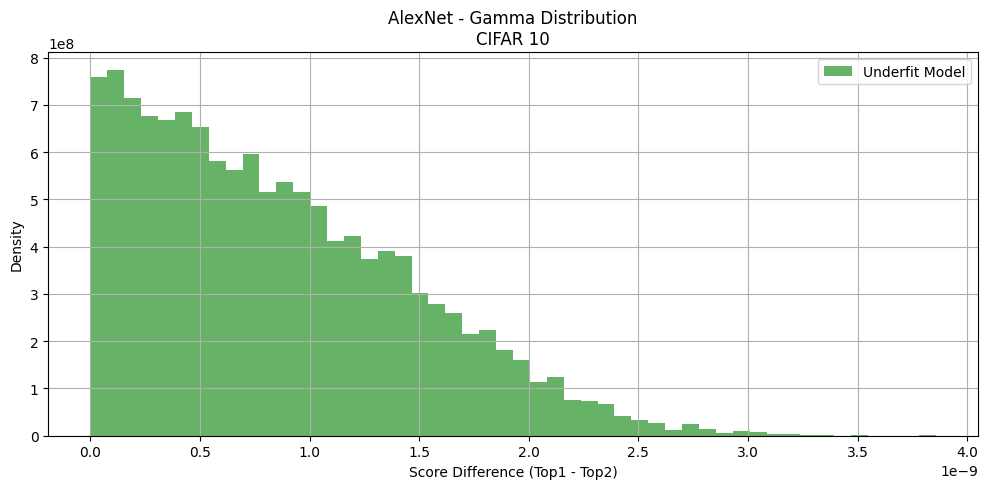

In [7]:
plt.figure(figsize=(10, 5))
plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
# plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
# plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title(f"AlexNet - Gamma Distribution\nCIFAR 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

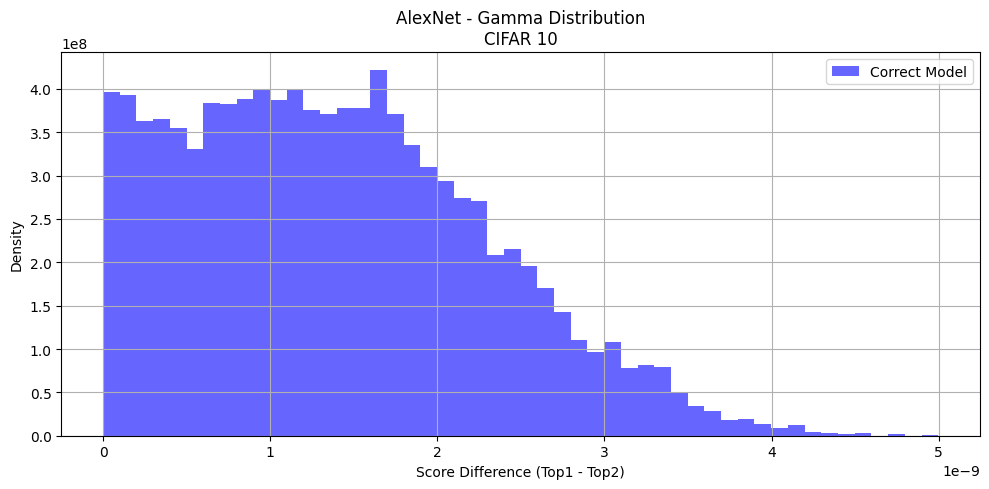

In [8]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
# plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title(f"AlexNet - Gamma Distribution\nCIFAR 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

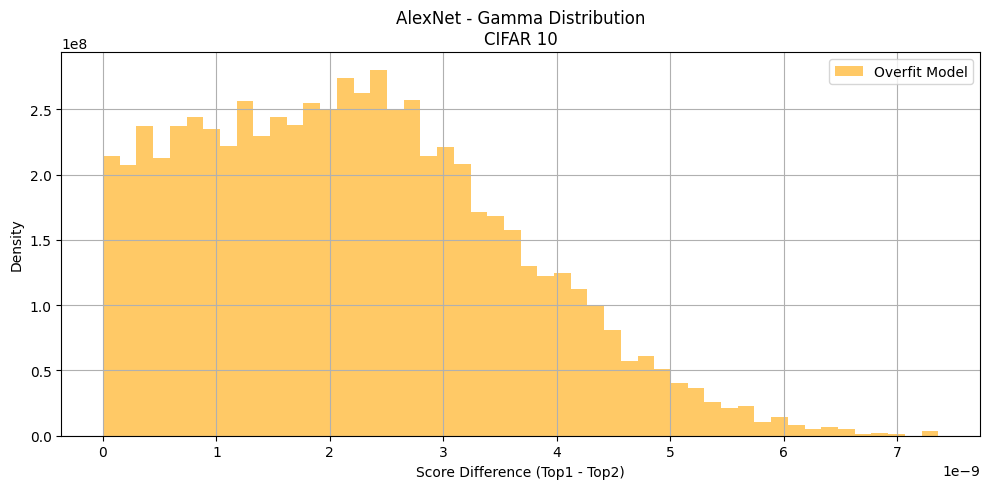

In [9]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
# plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title(f"AlexNet - Gamma Distribution\nCIFAR 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

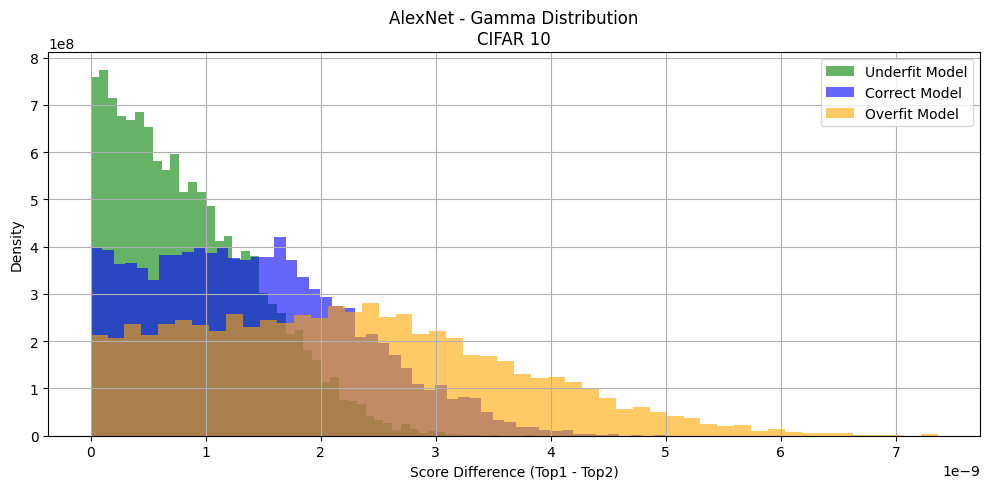

In [10]:
plt.figure(figsize=(10, 5))
plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title(f"AlexNet - Gamma Distribution\nCIFAR 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gamma_hist_alexnet_cifar10.png")
plt.show()

In [6]:
transform = transforms.Compose([
    transforms.Resize(224),  # Resize for AlexNet
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # CIFAR-10 mean/std
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [7]:
# Load pre-trained AlexNet
model = alexnet(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) # Optional: Learning rate scheduler

epochs = 100 # Adjust as needed

train_acc = list()
test_acc = list()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}, Train: ")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    train_acc_ = 100 * correct / total
    scheduler.step() # If using a scheduler

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(testloader, desc=f"Eval: ")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_acc_ = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, train acc: {train_acc_:.2f}%, test acc: {test_acc_:.2f}%")
    train_acc.append(train_acc_)
    test_acc.append(test_acc_)
    torch.save(model.state_dict(), f"ckpt_alexnet_cifar10/epoch_{epoch+1}.pth")

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, epochs + 1), test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"AlexNet CIFAR10 Accuracy Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"alexnet_cifar10_accuracy_curve.png")
plt.show()

Eval: 100%|██████████| 79/79 [00:08<00:00,  9.24it/s]


Epoch 1, Loss: 0.9080, train acc: 68.25%, test acc: 82.27%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.04it/s]


Epoch 2, Loss: 0.5083, train acc: 82.27%, test acc: 85.32%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.00it/s]


Epoch 3, Loss: 0.4420, train acc: 84.65%, test acc: 86.50%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.97it/s]


Epoch 4, Loss: 0.3981, train acc: 86.26%, test acc: 87.99%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.03it/s]


Epoch 5, Loss: 0.3664, train acc: 87.31%, test acc: 88.57%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.85it/s]


Epoch 6, Loss: 0.3432, train acc: 88.16%, test acc: 88.96%


Eval: 100%|██████████| 79/79 [00:09<00:00,  8.69it/s]


Epoch 7, Loss: 0.3234, train acc: 88.68%, test acc: 89.03%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.10it/s]


Epoch 8, Loss: 0.3057, train acc: 89.30%, test acc: 89.40%


Eval: 100%|██████████| 79/79 [00:09<00:00,  8.77it/s]


Epoch 9, Loss: 0.2917, train acc: 89.81%, test acc: 89.66%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.33it/s]


Epoch 10, Loss: 0.2762, train acc: 90.30%, test acc: 89.86%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.12it/s]


Epoch 11, Loss: 0.2621, train acc: 90.94%, test acc: 90.19%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.28it/s]


Epoch 12, Loss: 0.2510, train acc: 91.09%, test acc: 89.95%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.19it/s]


Epoch 13, Loss: 0.2403, train acc: 91.70%, test acc: 90.07%


Eval: 100%|██████████| 79/79 [00:09<00:00,  8.77it/s]


Epoch 14, Loss: 0.2353, train acc: 91.74%, test acc: 90.37%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.27it/s]


Epoch 15, Loss: 0.2189, train acc: 92.23%, test acc: 90.48%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.84it/s]


Epoch 16, Loss: 0.2157, train acc: 92.46%, test acc: 90.74%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.23it/s]


Epoch 17, Loss: 0.2072, train acc: 92.82%, test acc: 90.66%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.09it/s]


Epoch 18, Loss: 0.1983, train acc: 93.09%, test acc: 90.72%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.06it/s]


Epoch 19, Loss: 0.1925, train acc: 93.20%, test acc: 90.78%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.98it/s]


Epoch 20, Loss: 0.1855, train acc: 93.48%, test acc: 90.99%


Eval: 100%|██████████| 79/79 [00:09<00:00,  8.70it/s]


Epoch 21, Loss: 0.1762, train acc: 93.90%, test acc: 91.01%


Eval: 100%|██████████| 79/79 [00:09<00:00,  8.23it/s]


Epoch 22, Loss: 0.1709, train acc: 93.95%, test acc: 91.11%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.83it/s]


Epoch 23, Loss: 0.1643, train acc: 94.21%, test acc: 91.32%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.03it/s]


Epoch 24, Loss: 0.1588, train acc: 94.41%, test acc: 91.64%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.94it/s]


Epoch 25, Loss: 0.1564, train acc: 94.43%, test acc: 91.14%


Eval: 100%|██████████| 79/79 [00:09<00:00,  8.76it/s]


Epoch 26, Loss: 0.1488, train acc: 94.74%, test acc: 91.67%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.02it/s]


Epoch 27, Loss: 0.1436, train acc: 94.97%, test acc: 91.34%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.92it/s]


Epoch 28, Loss: 0.1398, train acc: 95.06%, test acc: 91.36%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.83it/s]


Epoch 29, Loss: 0.1347, train acc: 95.30%, test acc: 91.61%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.20it/s]


Epoch 30, Loss: 0.1305, train acc: 95.44%, test acc: 91.46%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.85it/s]


Epoch 31, Loss: 0.1264, train acc: 95.52%, test acc: 91.52%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.00it/s]


Epoch 32, Loss: 0.1261, train acc: 95.58%, test acc: 91.35%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.89it/s]


Epoch 33, Loss: 0.1175, train acc: 95.89%, test acc: 91.83%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.27it/s]


Epoch 34, Loss: 0.1135, train acc: 96.04%, test acc: 91.59%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.28it/s]


Epoch 35, Loss: 0.1098, train acc: 96.14%, test acc: 91.68%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.94it/s]


Epoch 36, Loss: 0.1059, train acc: 96.42%, test acc: 91.60%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.90it/s]


Epoch 37, Loss: 0.1042, train acc: 96.32%, test acc: 91.71%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.16it/s]


Epoch 38, Loss: 0.1040, train acc: 96.42%, test acc: 91.60%


Eval: 100%|██████████| 79/79 [00:09<00:00,  8.70it/s]


Epoch 39, Loss: 0.0987, train acc: 96.54%, test acc: 91.81%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.26it/s]


Epoch 40, Loss: 0.0960, train acc: 96.72%, test acc: 91.74%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.12it/s]


Epoch 41, Loss: 0.0933, train acc: 96.71%, test acc: 91.70%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.17it/s]


Epoch 42, Loss: 0.0902, train acc: 96.80%, test acc: 91.87%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.16it/s]


Epoch 43, Loss: 0.0890, train acc: 96.85%, test acc: 91.67%


Eval: 100%|██████████| 79/79 [00:09<00:00,  8.39it/s]


Epoch 44, Loss: 0.0864, train acc: 96.93%, test acc: 91.73%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.16it/s]


Epoch 45, Loss: 0.0818, train acc: 97.19%, test acc: 91.79%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.23it/s]


Epoch 46, Loss: 0.0813, train acc: 97.21%, test acc: 91.90%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.92it/s]


Epoch 47, Loss: 0.0789, train acc: 97.25%, test acc: 92.01%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.36it/s]


Epoch 48, Loss: 0.0770, train acc: 97.22%, test acc: 91.80%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.05it/s]


Epoch 49, Loss: 0.0743, train acc: 97.43%, test acc: 91.87%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.21it/s]


Epoch 50, Loss: 0.0710, train acc: 97.64%, test acc: 91.70%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.79it/s]


Epoch 51, Loss: 0.0697, train acc: 97.64%, test acc: 91.94%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.93it/s]


Epoch 52, Loss: 0.0683, train acc: 97.62%, test acc: 91.92%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.90it/s]


Epoch 53, Loss: 0.0665, train acc: 97.80%, test acc: 91.74%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.19it/s]


Epoch 54, Loss: 0.0640, train acc: 97.86%, test acc: 91.56%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.28it/s]


Epoch 55, Loss: 0.0624, train acc: 97.85%, test acc: 92.09%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.39it/s]


Epoch 56, Loss: 0.0627, train acc: 97.83%, test acc: 91.80%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.04it/s]


Epoch 57, Loss: 0.0617, train acc: 97.79%, test acc: 91.81%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.09it/s]


Epoch 58, Loss: 0.0616, train acc: 97.86%, test acc: 91.96%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.34it/s]


Epoch 59, Loss: 0.0557, train acc: 98.15%, test acc: 91.86%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.16it/s]


Epoch 60, Loss: 0.0550, train acc: 98.16%, test acc: 91.80%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.99it/s]


Epoch 61, Loss: 0.0554, train acc: 98.07%, test acc: 91.91%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.31it/s]


Epoch 62, Loss: 0.0512, train acc: 98.33%, test acc: 91.77%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.11it/s]


Epoch 63, Loss: 0.0546, train acc: 98.13%, test acc: 91.97%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.23it/s]


Epoch 64, Loss: 0.0516, train acc: 98.29%, test acc: 91.95%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.95it/s]


Epoch 65, Loss: 0.0503, train acc: 98.33%, test acc: 92.09%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.19it/s]


Epoch 66, Loss: 0.0478, train acc: 98.44%, test acc: 91.94%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.17it/s]


Epoch 67, Loss: 0.0471, train acc: 98.43%, test acc: 91.99%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.13it/s]


Epoch 68, Loss: 0.0457, train acc: 98.44%, test acc: 91.93%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.27it/s]


Epoch 69, Loss: 0.0465, train acc: 98.45%, test acc: 91.79%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.82it/s]


Epoch 70, Loss: 0.0448, train acc: 98.54%, test acc: 92.02%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.16it/s]


Epoch 71, Loss: 0.0448, train acc: 98.54%, test acc: 91.97%


Eval: 100%|██████████| 79/79 [00:08<00:00,  9.27it/s]


Epoch 72, Loss: 0.0434, train acc: 98.52%, test acc: 92.06%


Eval: 100%|██████████| 79/79 [00:08<00:00,  8.81it/s]


Epoch 73, Loss: 0.0421, train acc: 98.61%, test acc: 92.05%


Eval: 100%|██████████| 79/79 [00:09<00:00,  8.59it/s]


Epoch 74, Loss: 0.0427, train acc: 98.56%, test acc: 92.18%


Epoch 75/100, Train:  79%|███████▊  | 77/98 [00:36<00:08,  2.42it/s]

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, epochs + 1), test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"AlexNet CIFAR10 Accuracy Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"alexnet_cifar10_accuracy_curve.png")
plt.show()